In [1]:
import os
import numpy
from scipy import integrate, linalg
from matplotlib import pyplot
%matplotlib inline

In [2]:
class Panel:
    def __init__(self, xa, ya, xb, yb):
        self.xa, self.ya = xa, ya 
        self.xb, self.yb = xb, yb 
        
        self.xc, self.yc = (xa+xb)/2, (ya+yb)/2         
        self.length = numpy.sqrt((xb-xa)**2+(yb-ya)**2) 
        if xb-xa <= 0.0:
            self.beta = numpy.arccos((yb-ya)/self.length)
        elif xb-xa > 0.0:
            self.beta = numpy.pi + numpy.arccos(-(yb-ya)/self.length)
        if self.beta <= numpy.pi:
            self.loc = 'upper' # upper surface
        else:
            self.loc = 'lower' # lower surface
        self.sigma = 0.0 
        self.vt = 0.0    
        self.cp = 0.0    

def define_panels(x, y, N):
    panels = numpy.empty(N, dtype=object)
    for i in range(N):
        panels[i] = Panel(x[i], y[i], x[i+1], y[i+1])
    return panels

class Freestream:
    def __init__(self, u_inf, alpha):
        self.u_inf = u_inf
        self.alpha = alpha*numpy.pi/180.0 # degrees to radians
        
def integral(x, y, panel, dxdk, dydk):
    def integrand(s):
        return ( ((x - (panel.xa - numpy.sin(panel.beta)*s))*dxdk
                  +(y - (panel.ya + numpy.cos(panel.beta)*s))*dydk)
                / ((x - (panel.xa - numpy.sin(panel.beta)*s))**2
                   +(y - (panel.ya + numpy.cos(panel.beta)*s))**2) )
    return integrate.quad(integrand, 0.0, panel.length)[0]

def source_contribution_normal(panels):
    A = numpy.empty((panels.size, panels.size), dtype=float)
    # source contribution on a panel from itself
    numpy.fill_diagonal(A, 0.5)
    # source contribution on a panel from others
    for i, panel_i in enumerate(panels):
        for j, panel_j in enumerate(panels):
            if i != j:
                A[i, j] = 0.5/numpy.pi*integral(panel_i.xc, panel_i.yc, 
                                                panel_j,
                                                numpy.cos(panel_i.beta),
                                                numpy.sin(panel_i.beta))
    return A

def vortex_contribution_normal(panels):
    A = numpy.empty((panels.size, panels.size), dtype=float)
    # vortex contribution on a panel from itself
    numpy.fill_diagonal(A, 0.0)
    # vortex contribution on a panel from others
    for i, panel_i in enumerate(panels):
        for j, panel_j in enumerate(panels):
            if i != j:
                A[i, j] = -0.5/numpy.pi*integral(panel_i.xc, panel_i.yc, 
                                                 panel_j,
                                                 numpy.sin(panel_i.beta),
                                                 -numpy.cos(panel_i.beta))
    return A

def kutta_condition(A_source, B_vortex):

    b = numpy.empty(A_source.shape[0]+1, dtype=float)
    b[:-1] = B_vortex[0, :] + B_vortex[-1, :]
    b[-1] = - numpy.sum(A_source[0, :] + A_source[-1, :])
    return b

def build_singularity_matrix(A_source, B_vortex):
    A = numpy.empty((A_source.shape[0]+1, A_source.shape[1]+1), dtype=float)
    # source contribution matrix
    A[:-1, :-1] = A_source
    # vortex contribution array
    A[:-1, -1] = numpy.sum(B_vortex, axis=1)
    # Kutta condition array
    A[-1, :] = kutta_condition(A_source, B_vortex)
    return A

def build_freestream_rhs(panels, freestream):
    b = numpy.empty(panels.size+1,dtype=float)
    # freestream contribution on each panel
    for i, panel in enumerate(panels):
        b[i] = -freestream.u_inf * numpy.cos(freestream.alpha - panel.beta)
    # freestream contribution on the Kutta condition
    b[-1] = -freestream.u_inf*( numpy.sin(freestream.alpha-panels[0].beta)
                               +numpy.sin(freestream.alpha-panels[-1].beta) )
    return b

def compute_tangential_velocity(panels, freestream, gamma, A_source, B_vortex):
    A = numpy.empty((panels.size, panels.size+1), dtype=float)
    A[:, :-1] = B_vortex
    A[:, -1] = -numpy.sum(A_source, axis=1)
    b = freestream.u_inf*numpy.sin([freestream.alpha-panel.beta 
                                    for panel in panels])
    
    strengths = numpy.append([panel.sigma for panel in panels], gamma)
    
    tangential_velocities = numpy.dot(A, strengths) + b
    
    for i, panel in enumerate(panels):
        panel.vt = tangential_velocities[i]
        
def compute_pressure_coefficient(panels, freestream):
    for panel in panels:
        panel.cp = 1.0 - (panel.vt/freestream.u_inf)**2

In [3]:
x,y=numpy.loadtxt("naca0012.dat",dtype=float,unpack=True)
N,alpha,u_inf=len(x)-1,0,1
freestream = Freestream(u_inf,alpha)
panels = define_panels(x,y,N)
A_source = source_contribution_normal(panels)
B_vortex = vortex_contribution_normal(panels)
A = build_singularity_matrix(A_source, B_vortex)
b = build_freestream_rhs(panels, freestream)
strengths = numpy.linalg.solve(A, b)
for i , panel in enumerate(panels):
    panel.sigma = strengths[i]
gamma = strengths[-1]
compute_tangential_velocity(panels, freestream, gamma, A_source, B_vortex)

In [4]:
gamma

0.029471076261787663

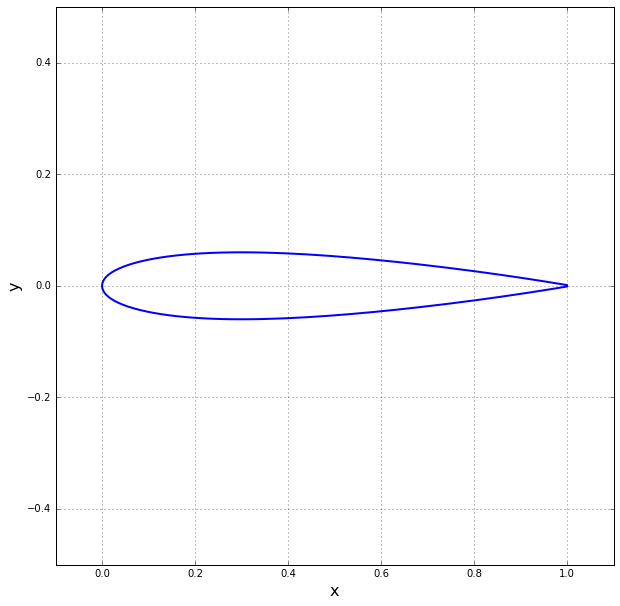

In [5]:
width = 10
pyplot.figure(figsize=(width, width))
pyplot.grid()
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
pyplot.plot(x,y,linestyle='-', linewidth=2)
pyplot.xlim(-0.1, 1.1)
pyplot.ylim(-0.5,0.5);

In [6]:
numpy.where(y==0)

(array([ 0, 65]),)

In [7]:
d_psi=2*numpy.pi/12
d_zeta=2*numpy.pi/12
a=numpy.linspace(0,11,12)


In [8]:
a=numpy.array([1,0,0])
b=numpy.array([0,1,0])
c=numpy.vstack((a,b))
numpy.cross(c[0,:],c[1,:])

array([0, 0, 1])

In [38]:
class Vortex_point_initial:
    def __init__(self,rv1,psi1,zeta1,beta1,miu1,lamda1):
        self.x=rv1*numpy.cos(beta1)*numpy.cos(psi1-zeta1)+miu1*zeta1
        self.y=rv1*numpy.cos(beta1)*numpy.sin(psi1-zeta1)
        self.z=rv1*numpy.sin(beta1)-lamda1*zeta1
        self.r=numpy.array([self.x,self.y,self.z])
        self.v_induced=0 #induced velocity

def define_vortex_points_initial(rv,psi,zeta,beta,miu,lamda):
    vortex_points_initial = numpy.empty((N*(N+1)),dtype=object)
    for i in range(N*(N+1)):
        vortex_points_initial[i]=Vortex_point_initial(rv,psi[i],zeta[i],beta[i],miu[i],lamda[i])
    return vortex_points_initial

class Vortex_points:
    def __init__(self,r):
        self.x, self.y, self.z =r[0],r[1],r[2]
        self.v_induced=0
        self.r=r



In [39]:
N=12
R=50 #wing span
omiga=5*2*numpy.pi  # angular velocity
rv=0.5*R
d_psi,d_zeta=numpy.pi*2/N,numpy.pi*2/N
psi,zeta=numpy.zeros(N*(N+1)),numpy.zeros(N*(N+1))               
miu=numpy.zeros(N*(N+1));lamda=numpy.zeros(N*(N+1));beta=numpy.zeros(N*(N+1))
## these parameters are zero because we assume helicopter hover
j=0;k=0
for i in range(N*(N+1)):
    if (j==12):
        k=k+1
        j=0
    psi[i]=i*d_psi
    zeta[i]=k*d_zeta
    j=j+1

In [66]:
vortex_points_initial=define_vortex_points_initial(rv,psi,zeta,beta,miu,lamda)
vortex_points= [[0 for k in range(N)]  for j in range(N+1)]
for j in range(N+1):
    for k in range(N):
        vortex_points[j][k]=Vortex_points(vortex_points_initial[0].r) 

for k in range(N):
    vortex_points[0][k]=Vortex_points(vortex_points_initial[k].r) #initial condition

In [136]:
def induced_velocity(point,vortex_points,gamma,n):
    v_induced=0;
    #calculate induced velocity at point(j,k)
    for a in range (N):
        for b in range (N):
            r1=point-vortex_points[a][b].r # vector from  p(a,b) to p
            r2=point-vortex_points[a+1][b].r# vector from  p(a,b+1) to p
            l=vortex_points[a+1][b].r-vortex_points[a][b].r  # one vortex line
            r1_value=numpy.sqrt(r1[0]**2+r1[1]**2+r1[2]**2)
            r2_value=numpy.sqrt(r2[0]**2+r2[1]**2+r2[2]**2)
            l_value=numpy.sqrt(l[0]**2+l[1]**2+l[2]**2)
            theta1=numpy.arccos(numpy.dot(l,r1)/l_value/r1_value)
            theta2=numpy.arccos(numpy.dot(l,r2)/l_value/r2_value)
            h=r1_value*numpy.sin(theta1)
            cross=numpy.cross(l,r1)
            e=cross/numpy.sqrt(cross[0]**2+cross[1]**2+cross[2]**2)
            rc=1.12*numpy.sqrt(4*(0.1*gamma+0.000146)*zeta[i]/omiga) #radius of vortex core 
            v=gamma/4/numpy.pi*h/((rc**(2*n)+h**(2*n))**(1/n))*(numpy.cos(theta1)-numpy.cos(theta2))*e
            v_induced=v_induced+v
    return v_induced
    

In [137]:
n=1
for j in range (N):
    for k in range(N):
        point=vortex_points[j][k].r
        v_induced=induced_velocity(point,vortex_points,gamma,n)
        vortex_points[j+1][k+1]=vortex_points[j][k]+2/omiga*d_psi*v_induced
        

/home/gil/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:12: RuntimeWarning: invalid value encountered in double_scalars
/home/gil/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:13: RuntimeWarning: invalid value encountered in double_scalars
/home/gil/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:16: RuntimeWarning: invalid value encountered in true_divide
/home/gil/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:12: RuntimeWarning: invalid value encountered in arccos


TypeError: unsupported operand type(s) for +: 'Vortex_points' and 'float'

In [135]:
vortex_points[12][11].r

array([ 25.,   0.,   0.])

In [100]:
a=0;c=100
if a>0:
    c=1


In [101]:
c

100